# How can frog grow its tail back?


In [68]:
#!pip install anndata
#!pip install 'scanpy[leiden]'

In this starter we provide some built-in functions for PCA and subsequent Leiden Clustering. We do not reqruire you write down PCA in this task, but for more details as to how you should use it, `scanpy` uses the `sklearn` PCA routine - for `R` users, there might be some usage discrepancies. Scaling/centering data is not automatically done and can be a careful choice here. For additional information on single cell specific use, you can consult this [tutorial](https://training.galaxyproject.org/training-material/topics/single-cell/tutorials/scrna-scanpy-pbmc3k/tutorial.html#dimensionality-reduction).


For the project, ask yourself some questions: why do we do PCA? how does this affect our data? how does the scaling affect? should we scale? what is the impact of the processing steps? does the interpretation carry over from classical ML use? How does the two formulations of PCA help you understand what is going on here?

## Processing the data

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
#extract_dir = "/content/drive/MyDrive/TA/Frogtail_files/" # use your own directory
#adata = sc.read_h5ad('cleaned_processed_frogtail.h5ad') # file path
adata = sc.read_h5ad('C:/Users/xsy/Desktop/cleaned_processed_frogtail.h5ad')
sc.pp.filter_genes(adata, min_cells=3)  
sc.pp.filter_cells(adata, min_genes=200) 
#adata = adata[~np.isnan(adata.X).any(1), :] 
print(adata.obs.head())
print(adata.var)

c:\Users\xsy\anaconda3\Lib\site-packages\anndata\_core\aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


        barcode_cells                cell  sample DevelopmentalStage  \
0  AAACCTGAGCTAGTTC.1  AAACCTGAGCTAGTTC.1  SIGAB5               st40   
1  AAACCTGGTGGGTCAA.1  AAACCTGGTGGGTCAA.1  SIGAB5               st40   
2  AAACCTGGTTTGTTGG.1  AAACCTGGTTTGTTGG.1  SIGAB5               st40   
3  AAACGGGGTCGGCATC.1  AAACGGGGTCGGCATC.1  SIGAB5               st40   
4  AAACGGGTCCTACAGA.1  AAACGGGTCCTACAGA.1  SIGAB5               st40   

   DaysPostAmputation        cluster         X          Y CellCyclePhase  \
0                   3  Erythrocyte 4 -6.395430   0.832323            G2M   
1                   3      Myeloid 1 -2.428271  13.826715             G1   
2                   3  Beta ionocyte -1.398049 -14.653897             G1   
3                   3  Erythrocyte 4 -5.863765   0.489598            G2M   
4                   3    Goblet cell  2.106444  -6.594430             G1   

   Sample       Lane Condition  batch  n_genes  
0  SIGAB5  SLX-15583    ST40_3      3     2135  
1  SIGAB5  S

We need to select a timepoint. Let's plot them out first.

<Axes: xlabel='DaysPostAmputation', ylabel='Count'>

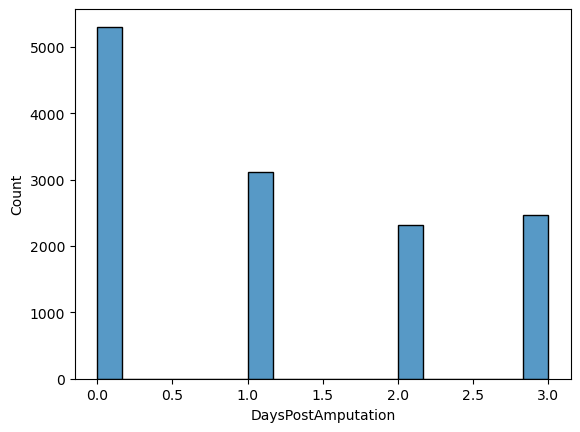

In [2]:
import seaborn as sns
sns.histplot(adata.obs['DaysPostAmputation'])

Selecting timepoint 0 (Day of amputation).

In [3]:
adata = adata[adata.obs['DaysPostAmputation'] == 0] # Subset on the time point 0
adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer
if isinstance(adata.X, np.ndarray):
    dense_matrix = adata.X
else:
    dense_matrix = adata.X.toarray()  


gene_variances = np.var(dense_matrix, axis=0)
print(gene_variances)

top_10_variable_indices = np.argsort(-gene_variances)[:1000]
top_10_Not_variable_indices = np.argsort(gene_variances)[:1000]
inactive_gene_names=top_10_Not_variable_indices
print(adata.var_names[top_10_variable_indices])
print(adata.var_names[top_10_Not_variable_indices])
adata = adata[:, ~adata.var_names.isin(inactive_gene_names)].copy()#we can select the most and less variable gene
hvg_adata=adata[:, ~adata.var_names.isin(top_10_variable_indices)].copy() 


C:\Users\xsy\AppData\Local\Temp\ipykernel_42368\1878354851.py:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer


[0.02821057 0.         0.03263026 ... 0.02451112 0.45858014 0.01731854]
Index(['hbd.S', 'Xelaev18045099m.g', 'hbd.L', 'Xelaev18045098m.g',
       'Xelaev18047464m.g', 'Xelaev18045083m.g', 'Xelaev18045096m.g',
       'Xelaev18045084m.g', 'Xelaev18047460m.g', 'Xelaev18047453m.g',
       ...
       'Xelaev18038264m.g', 'rtn1.L', 'rgs2.S', 'pnp.S', 'rhoa.S', 'hnrnpa3.S',
       'cdknx.L', 'Xelaev18041434m.g', 'cybb.L', 'ctnnb1.S'],
      dtype='object', length=1000)
Index(['odam.L', 'fgb.L', 'nr1h5.L', 'loc100491454.S', 'Xelaev18042655m.g',
       'Xelaev18031958m.g', 'Xelaev18042620m.g', 'loc101735213.S',
       'Xelaev18031970m.g', 'loc100498452.L',
       ...
       'cdc20b.L', 'lmod1.L', 'Xelaev18033886m.g', 'ankrd34a.S',
       'Xelaev18040897m.g', 'Xelaev18034487m.g', 'c1s.L', 'slc22a13.L',
       'Xelaev18040603m.g', 'otog.L'],
      dtype='object', length=1000)


## PCA without scale

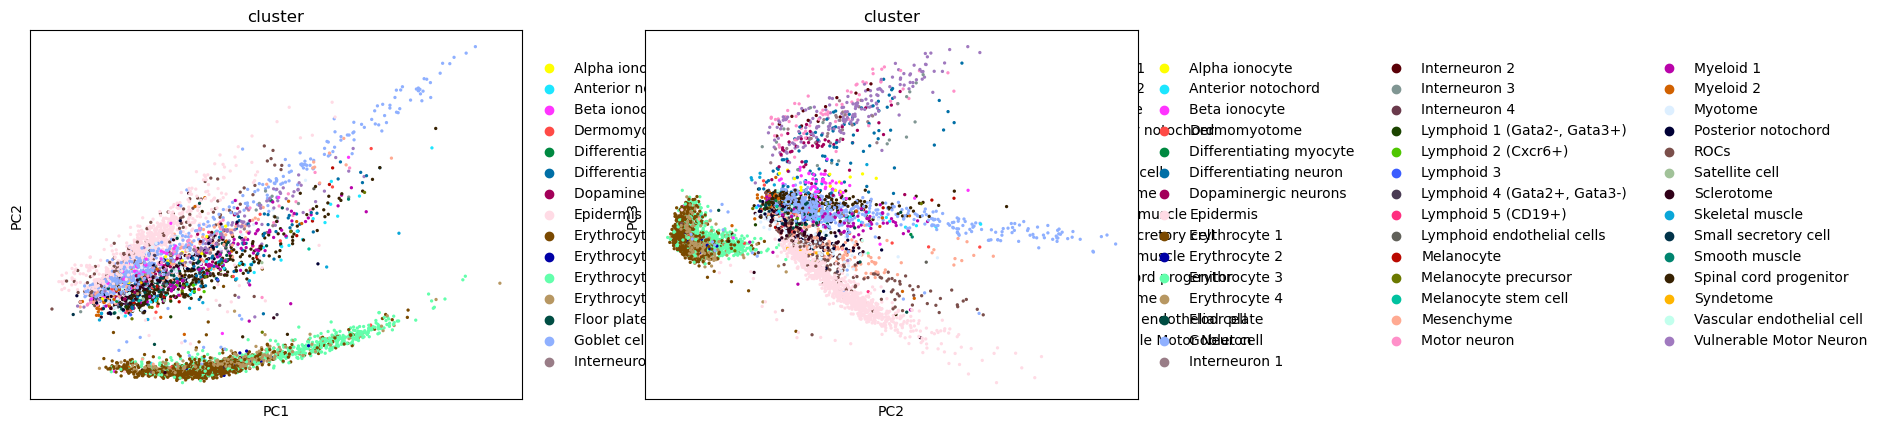

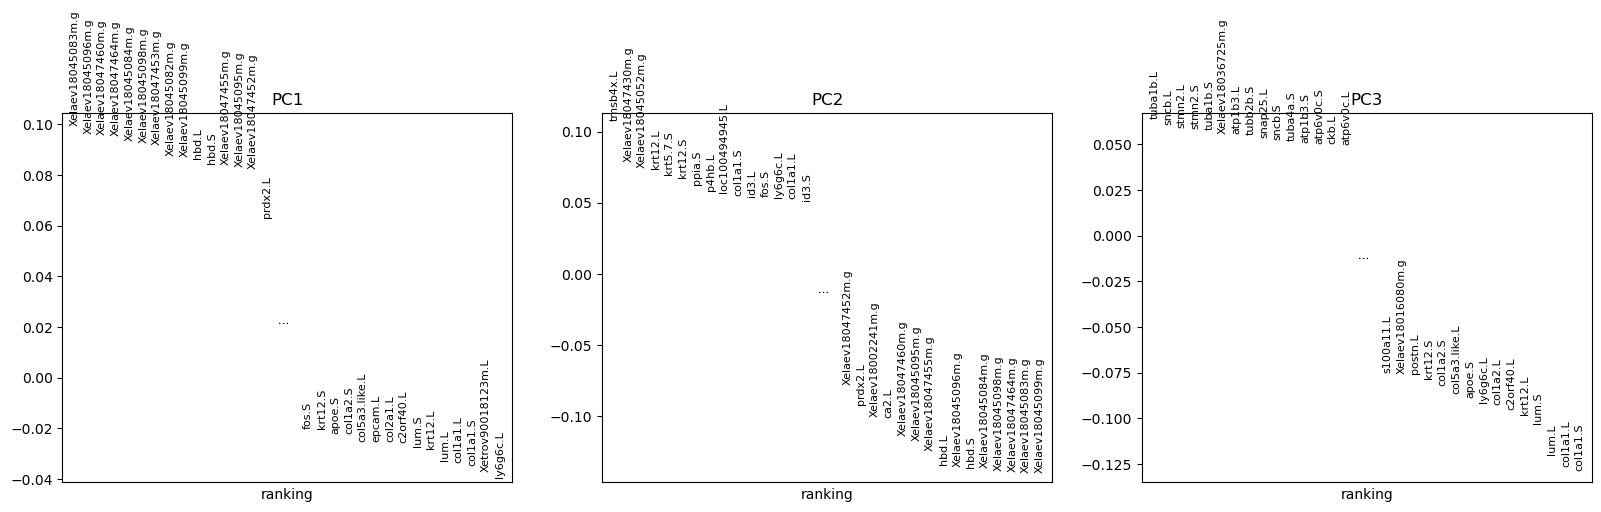

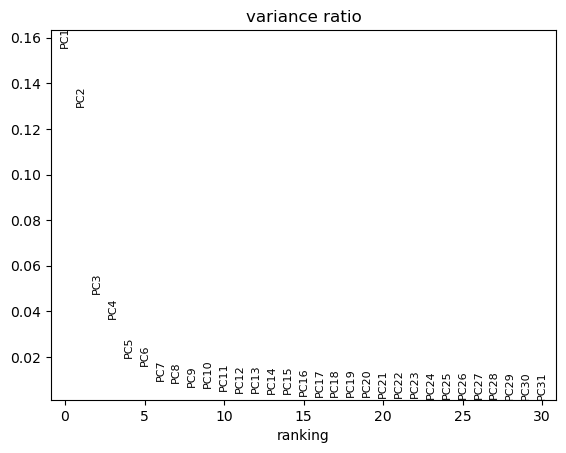

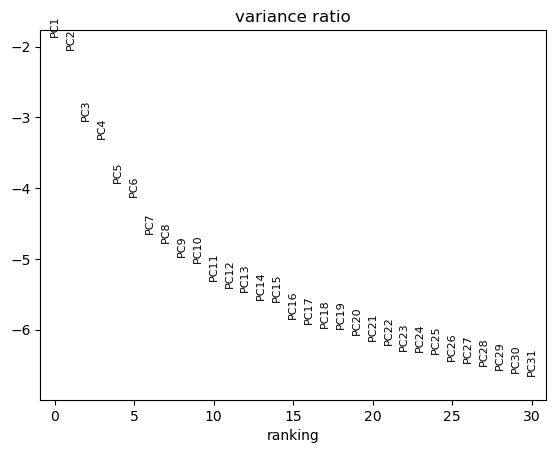

In [4]:
sc.pp.log1p(hvg_adata)
# Do PCA on the highly variable genes data - you might need to lognormalize to select HVG
sc.tl.pca(hvg_adata)
#sc.pp.pca(hvg_adata)

sc.pl.pca_overview(hvg_adata, color='cluster', components= ['1,2', '2,3']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3
sc.pl.pca_variance_ratio(hvg_adata, log=True) # Plot the variance ratio

## PCA with scale



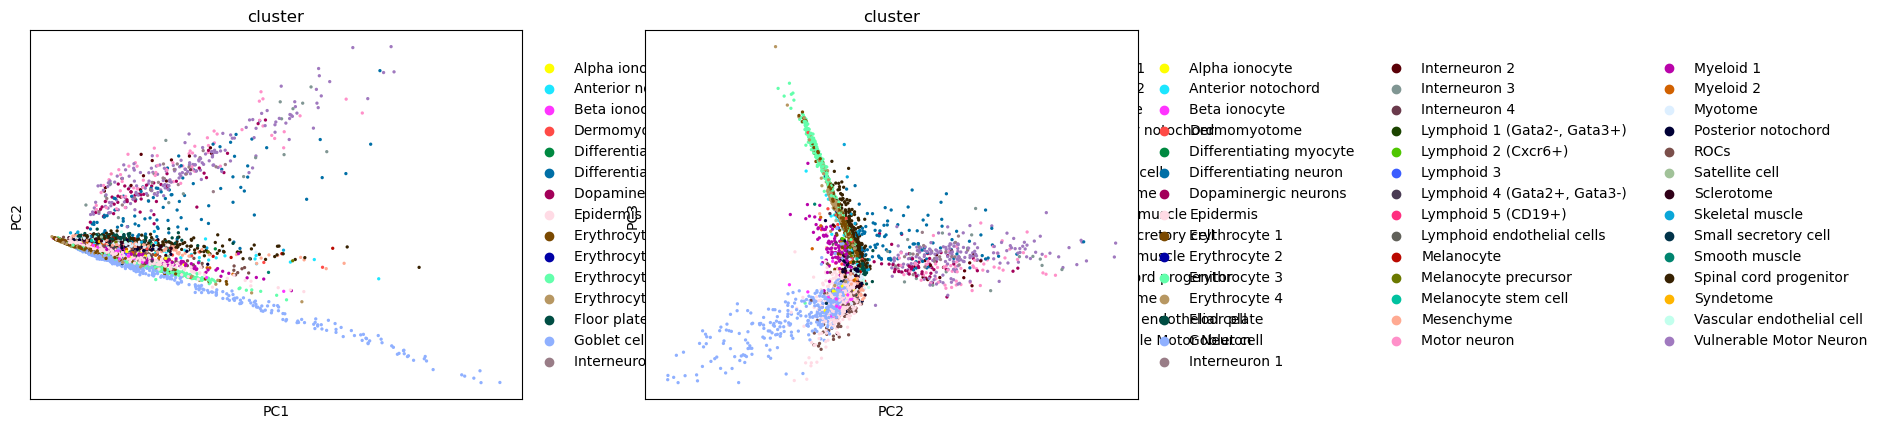

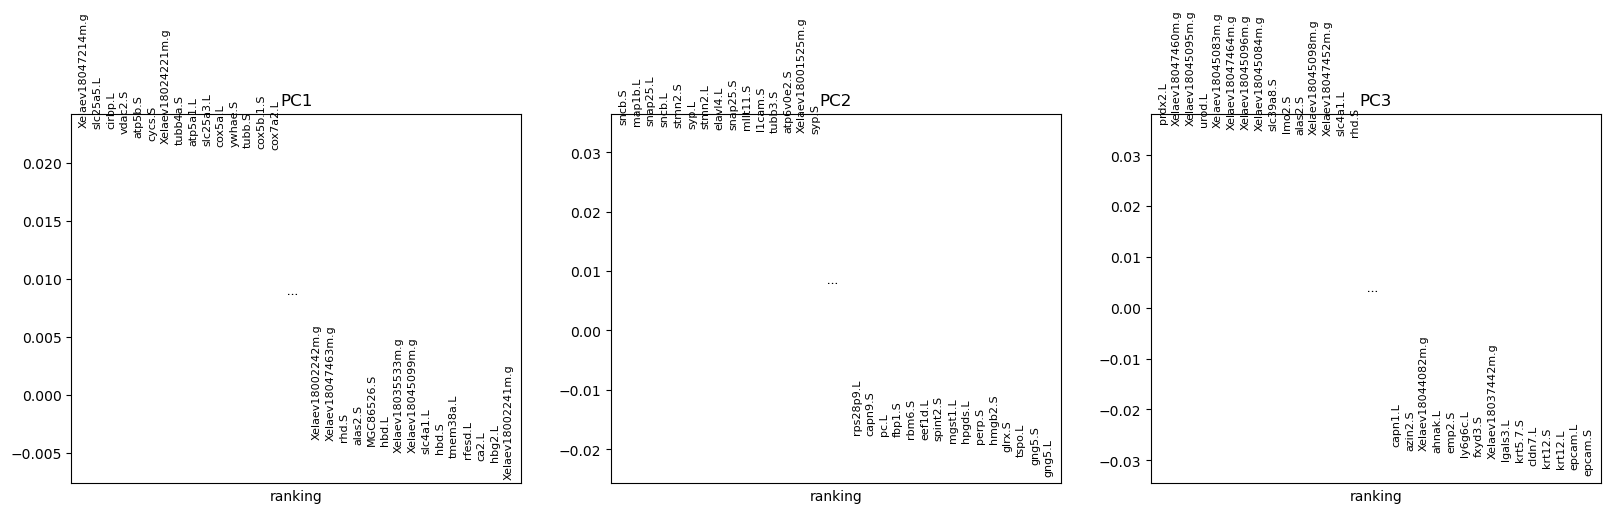

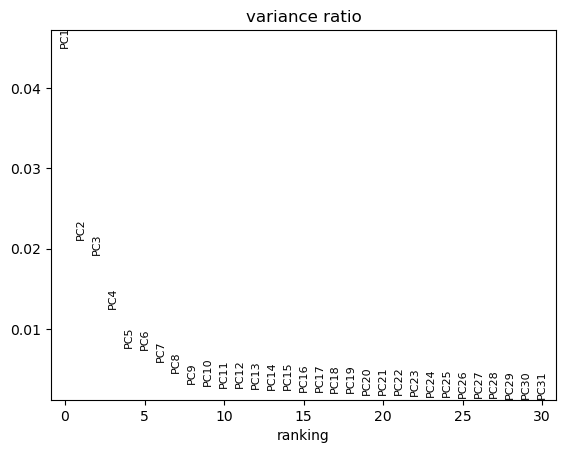

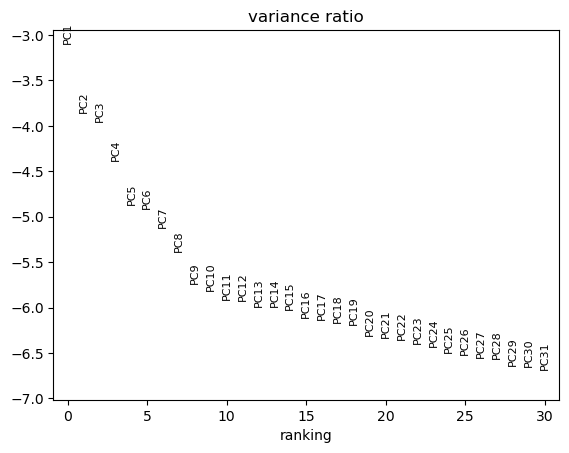

In [5]:
sc.pp.scale(hvg_adata) # Scale data

# Do PCA on the highly variable genes data - you might need to lognormalize to select HVG
sc.tl.pca(hvg_adata)
sc.pp.pca(hvg_adata)

sc.pl.pca_overview(hvg_adata, color='cluster', components= ['1,2', '2,3']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3
sc.pl.pca_variance_ratio(hvg_adata, log=True) # Plot the variance ratio

##
 (Without Scaling:)The variance ratio plot shows that the first principal component (PC1) explains a large proportion of the variance in the data, suggesting that a few high-variance features are dominating the data structure. This often happens when the data is not scaled and some features have much larger values than others.

 (With Scaling):After scaling, the variance explained by each principal component is more evenly distributed. This indicates that no single feature is dominating the PCA, and the variance is more uniformly captured by the principal components. It provides a more balanced view of the data's structure.

## Apply Leiden clustering

In [11]:
# Whitening step - create neighbors graph based on PCA
sc.pp.neighbors(hvg_adata, n_neighbors=10, n_pcs=30) # Create neighbors graph - n_pcs takes the number of principal components from PCA you keep for this step
sc.tl.leiden(hvg_adata, resolution=0.5)  # Apply Leiden clustering, you can adjust the resolution parameter
print(hvg_adata)

AnnData object with n_obs × n_vars = 5302 × 26166
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch', 'n_genes', 'leiden', 'louvain'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'cluster_colors', 'neighbors', 'leiden', 'louvain', 't_test'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


## Louvain method

In [10]:
# Whitening step - create neighbors graph based on PCA
sc.pp.neighbors(hvg_adata, n_neighbors=10, n_pcs=30) # Create neighbors graph - n_pcs takes the number of principal components from PCA you keep for this step
sc.tl.louvain(hvg_adata, resolution=0.5)  # Apply Leiden clustering, you can adjust the resolution parameter
print(hvg_adata)

AnnData object with n_obs × n_vars = 5302 × 26166
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch', 'n_genes', 'leiden', 'louvain'
    var: 'n_cells', 'mean', 'std'
    uns: 'log1p', 'pca', 'cluster_colors', 'neighbors', 'leiden', 'louvain', 't_test'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'


## Compare our cluster with labeled cluster

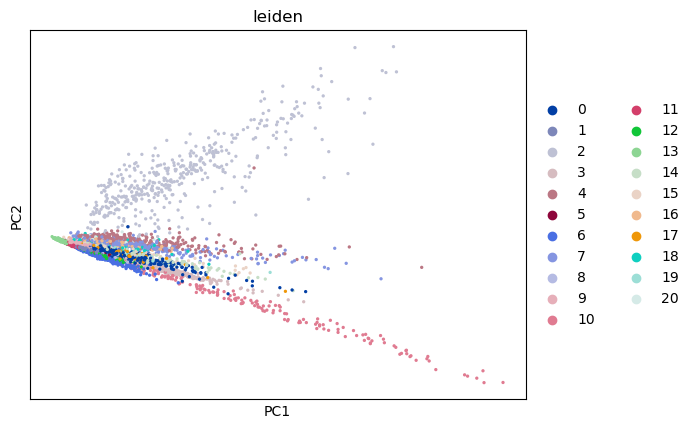

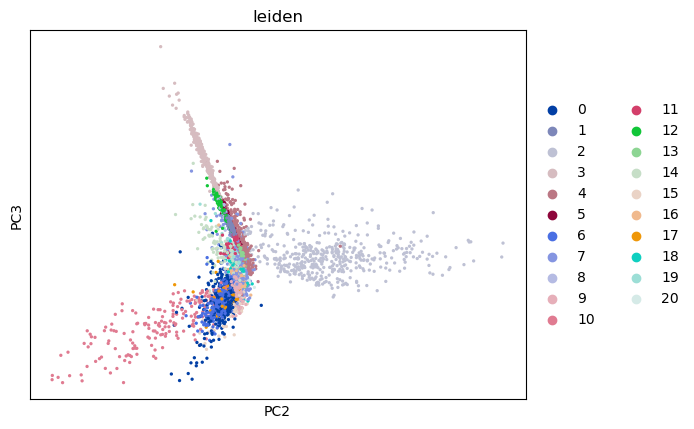

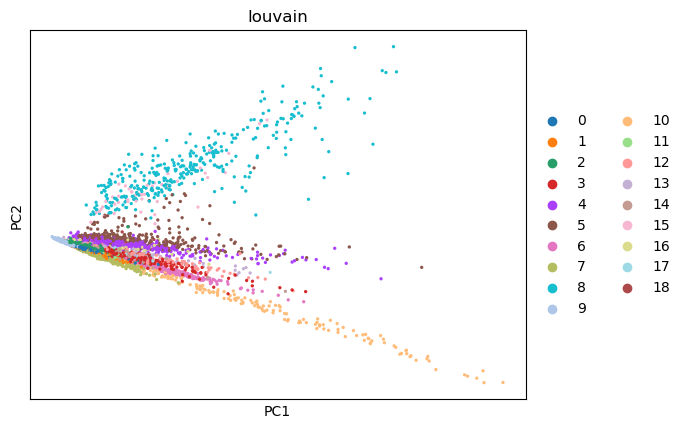

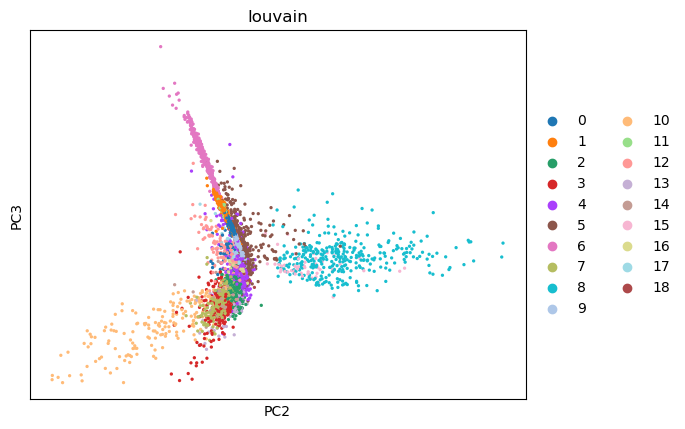

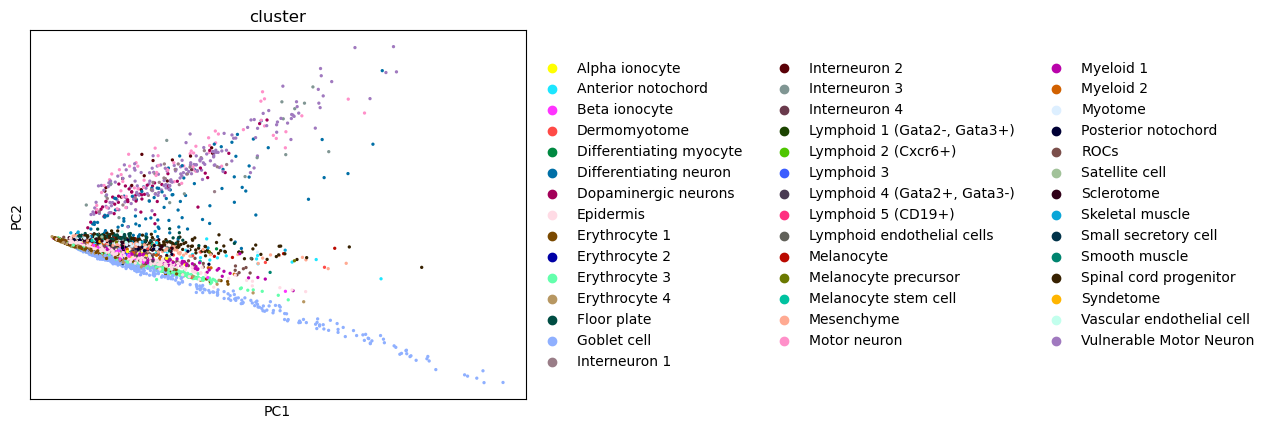

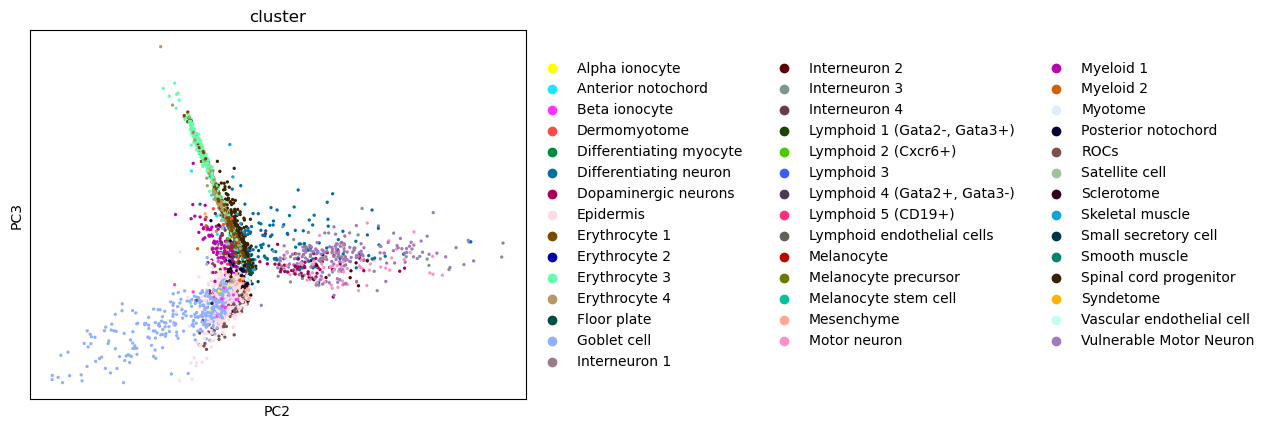

In [13]:
# If you have a column in `hvg_adata.obs` called 'predicted_clusters' from the paper:
sc.pl.pca(hvg_adata, color='leiden', components=['1,2'])# Plotting PC1/PC2 with colors from Leiden labels
sc.pl.pca(hvg_adata, color='leiden', components=['2,3'])

sc.pl.pca(hvg_adata, color='louvain', components=['1,2'])# Plotting PC1/PC2 with colors from louvain labels
sc.pl.pca(hvg_adata, color='louvain', components=['2,3'])


sc.pl.pca(hvg_adata, color='cluster', components=['1,2'])# Plotting PC1/PC2 with colors from original paper cluster
sc.pl.pca(hvg_adata, color='cluster', components=['2,3'])

##sc.pl.pca(hvg_adata, color=['leiden']) # Plotting PC1/PC2 with colors from Leiden labels
##sc.pl.pca(hvg_adata, color=['cluster']) # Plotting PC1/PC2 with colors from original paper cluster


## Umap and Tsne visualization

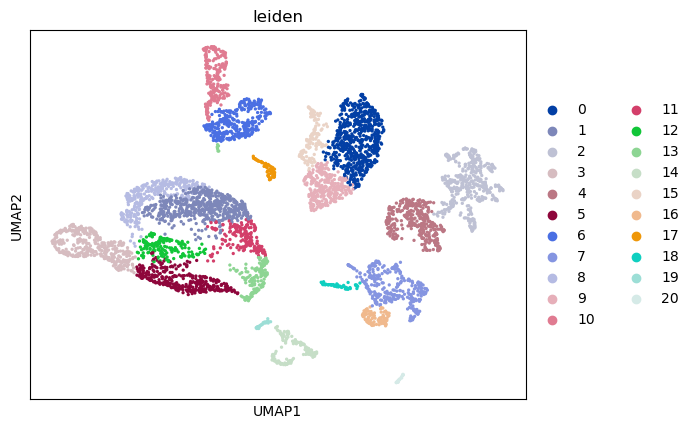

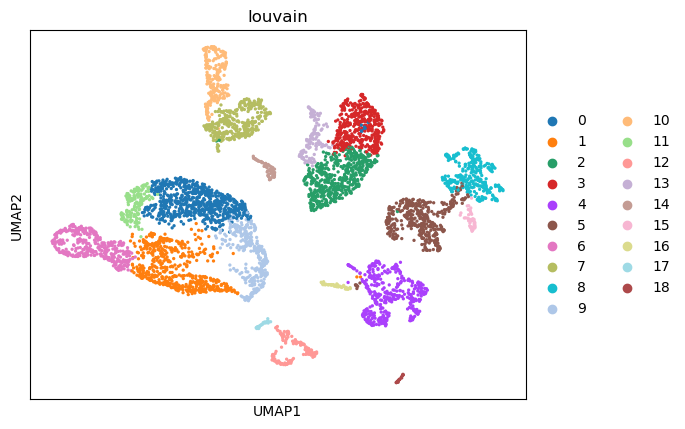

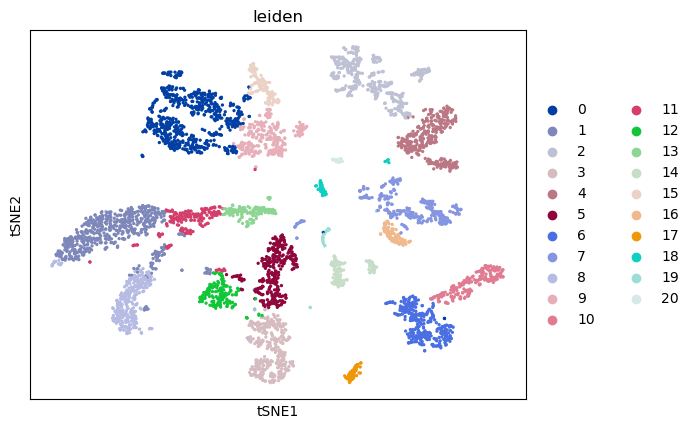

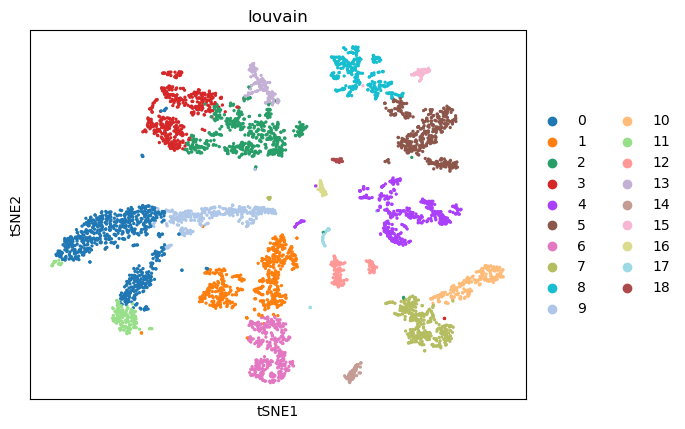

In [15]:
# Umap visualiztion
sc.tl.umap(hvg_adata)
sc.pl.umap(hvg_adata, color=['leiden'])
sc.pl.umap(hvg_adata, color=['louvain'])
#  t-SNE
sc.tl.tsne(hvg_adata)
sc.pl.tsne(hvg_adata, color=[ 'leiden'])
sc.pl.tsne(hvg_adata, color=['louvain'])
#sc.tl.umap(hvg_adata)
#sc.pl.umap(hvg_adata, color=['dbscan'], legend_loc='on data')


In [18]:
# filter 17 th catagory cluster
roc_cells_leiden= hvg_adata[hvg_adata.obs['leiden'] == '12']
roc_cells2_louvain = hvg_adata[hvg_adata.obs['louvain'] == '9']




## Ari & Silhouette_score & Fowlkes-Mallows Index

In [19]:
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(hvg_adata.obs['cluster'], hvg_adata.obs['leiden'])
print(f"Adjusted Rand Index (ARI): {ari}")

from sklearn.metrics import silhouette_score
# sil_score
sil_score = silhouette_score(hvg_adata.obsm['X_pca'], hvg_adata.obs['leiden'])
print(f"Silhouette Score: {sil_score}")

from sklearn.metrics import fowlkes_mallows_score

# 计算 Fowlkes-Mallows Index
fmi = fowlkes_mallows_score(hvg_adata.obs['cluster'], hvg_adata.obs['leiden'])
print(f"Fowlkes-Mallows Index: {fmi}")


Adjusted Rand Index (ARI): 0.4685409045984517
Silhouette Score: 0.13774514198303223
Fowlkes-Mallows Index: 0.529291176478003


In [20]:
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(hvg_adata.obs['cluster'], hvg_adata.obs['louvain'])
print(f"Adjusted Rand Index (ARI): {ari}")

from sklearn.metrics import silhouette_score
# sil_score
sil_score = silhouette_score(hvg_adata.obsm['X_pca'], hvg_adata.obs['louvain'])
print(f"Silhouette Score: {sil_score}")

from sklearn.metrics import fowlkes_mallows_score

# 计算 Fowlkes-Mallows Index
fmi = fowlkes_mallows_score(hvg_adata.obs['cluster'], hvg_adata.obs['louvain'])
print(f"Fowlkes-Mallows Index: {fmi}")

Adjusted Rand Index (ARI): 0.4690234294344671
Silhouette Score: 0.15795202553272247
Fowlkes-Mallows Index: 0.5263093821431996


In [21]:
print(hvg_adata.obs['cluster'].value_counts())

cluster
Erythrocyte 1                  1121
Epidermis                       919
Erythrocyte 3                   684
Goblet cell                     553
Spinal cord progenitor          284
Erythrocyte 4                   275
ROCs                            174
Vulnerable Motor Neuron         172
Mesenchyme                      127
Differentiating neuron          103
Myeloid 1                        99
Sclerotome                       98
Myotome                          78
Floor plate                      77
Motor neuron                     64
Beta ionocyte                    50
Posterior notochord              50
Dopaminergic neurons             48
Myeloid 2                        46
Anterior notochord               34
Interneuron 1                    25
Dermomyotome                     22
Vascular endothelial cell        21
Interneuron 3                    18
Melanocyte precursor             16
Lymphoid 4 (Gata2+, Gata3-)      16
Erythrocyte 2                    16
Small secretory cell

## Marker gene selection  wilcoxon& t test

c:\Users\xsy\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


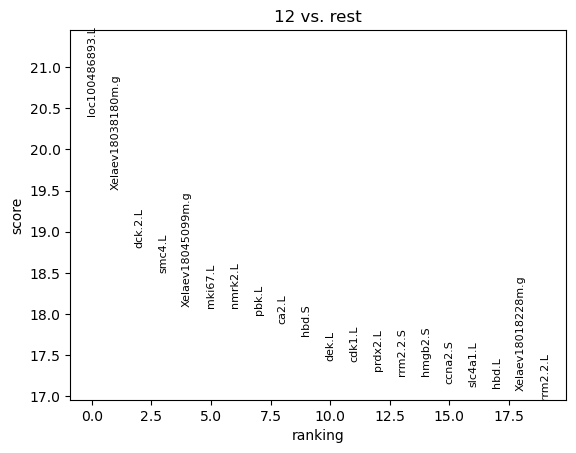

['loc100486893.L' 'Xelaev18038180m.g' 'dck.2.L' 'smc4.L'
 'Xelaev18045099m.g' 'mki67.L' 'nmrk2.L' 'pbk.L' 'ca2.L' 'hbd.S' 'dek.L'
 'cdk1.L' 'prdx2.L' 'rrm2.2.S' 'hmgb2.S' 'ccna2.S' 'slc4a1.L' 'hbd.L'
 'Xelaev18018228m.g' 'rrm2.2.L' 'nmrk2.S' 'spc25.L' 'Xelaev18045098m.g'
 'anp32c.S' 'Xelaev18047464m.g' 'Xelaev18020619m.g' 'Xelaev18002241m.g'
 'ccna2.L' 'Xelaev18036119m.g' 'cks1b.L' 'stmn1.L' 'nuf2.L' 'hmgb2.L'
 'blvrb.L' 'kif2c.L' 'eif5a.L' 'Xelaev18047575m.g' 'cenpa.L'
 'Xelaev18038083m.g' 'ran.S' 'ube2c.S' 'Xelaev18047455m.g' 'mthfd2.L'
 'rhd.S' 'Xelaev18037841m.g' 'loc100498440.like.L' 'spc24.L' 'h2afz.L'
 'loc100498230.S' 'rnaseh2b.L']


In [24]:
sc.tl.rank_genes_groups(hvg_adata, groupby='leiden',groups=['12'], method='wilcoxon', key_added='wilcoxon')

sc.pl.rank_genes_groups(hvg_adata, n_genes=20, sharey=False, key='wilcoxon')

top_n=50
rank_genes_df_wil = pd.DataFrame(hvg_adata.uns['wilcoxon']['names'])
wilcoxon_genes =hvg_adata.uns['wilcoxon']['names']['12'][:top_n]  

print(wilcoxon_genes)

c:\Users\xsy\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


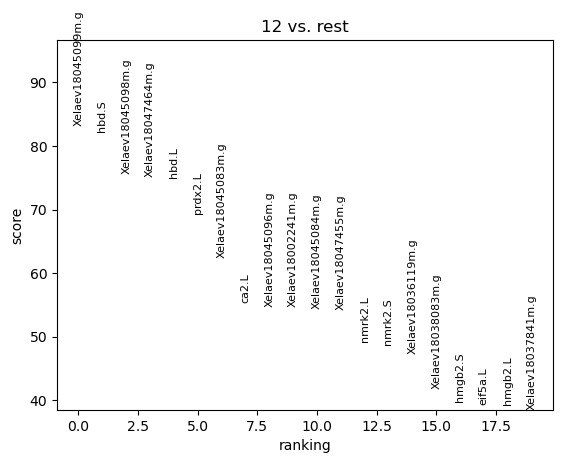

['Xelaev18045099m.g' 'hbd.S' 'Xelaev18045098m.g' 'Xelaev18047464m.g'
 'hbd.L' 'prdx2.L' 'Xelaev18045083m.g' 'ca2.L' 'Xelaev18045096m.g'
 'Xelaev18002241m.g' 'Xelaev18045084m.g' 'Xelaev18047455m.g' 'nmrk2.L'
 'nmrk2.S' 'Xelaev18036119m.g' 'Xelaev18038083m.g' 'hmgb2.S' 'eif5a.L'
 'hmgb2.L' 'Xelaev18037841m.g' 'blvrb.L' 'Xelaev18003627m.g'
 'Xelaev18000107m.g' 'Xelaev18038180m.g' 'slc4a1.L' 'loc100486893.L'
 'rpl8.L' 'Xelaev18045095m.g' 'rps27a.S' 'Xelaev18011978m.g' 'rps20.L'
 'Xelaev18003966m.g' 'Xelaev18045525m.g' 'rplp1.L' 'Xelaev18047575m.g'
 'rpsa.S' 'anp32c.S' 'rpl18.S' 'rps8.S' 'rpl13.L' 'Xelaev18016211m.g'
 'rplp0.S' 'Xelaev18039125m.g' 'rhd.S' 'rpl3.L' 'rps6.S' 'rps8.L' 'rbm6.S'
 'Xelaev18033797m.g' 'tmem14c.L']


In [25]:
sc.tl.rank_genes_groups(hvg_adata, groupby='leiden', groups=['12'],method='t-test',key_added='t_test')
top_n=50
#t-test
sc.pl.rank_genes_groups(hvg_adata, n_genes=20, sharey=False, key='t_test')
rank_genes_df_t = pd.DataFrame(hvg_adata.uns['t_test']['names'])
t_test_genes = hvg_adata.uns['t_test']['names']['12'][:top_n]
print(t_test_genes )



## Compare wil and T test By Venn

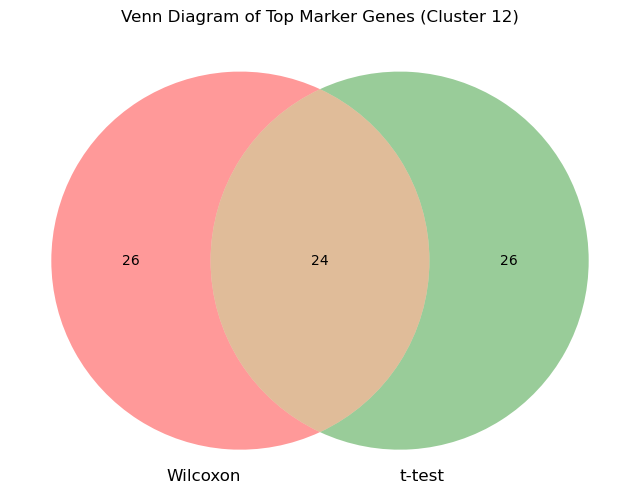

In [26]:
wilcoxon_set = set(wilcoxon_genes)
t_test_set = set(t_test_genes)

from matplotlib_venn import venn2
plt.figure(figsize=(8, 6))
venn2([wilcoxon_set, t_test_set], ('Wilcoxon', 't-test'))
plt.title('Venn Diagram of Top Marker Genes (Cluster 12)')
plt.show()


## Marker gene selection in Louvain method


c:\Users\xsy\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


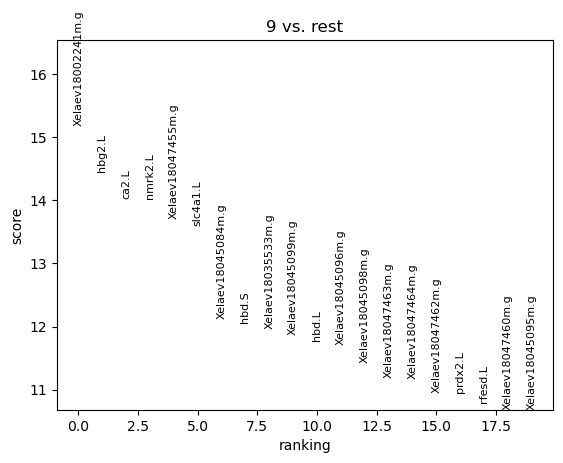

['Xelaev18002241m.g' 'hbg2.L' 'ca2.L' 'nmrk2.L' 'Xelaev18047455m.g'
 'slc4a1.L' 'Xelaev18045084m.g' 'hbd.S' 'Xelaev18035533m.g'
 'Xelaev18045099m.g' 'hbd.L' 'Xelaev18045096m.g' 'Xelaev18045098m.g'
 'Xelaev18047463m.g' 'Xelaev18047464m.g' 'Xelaev18047462m.g' 'prdx2.L'
 'rfesd.L' 'Xelaev18047460m.g' 'Xelaev18045095m.g' 'alas2.S'
 'Xelaev18045083m.g' 'rhd.S' 'fam132b.L' 'gsta1.S' 'nmrk2.S' 'mthfd2.L'
 'MGC86526.S' 'Xelaev18036119m.g' 'blvrb.L' 'sptb.L' 'tmem38a.L' 'lmo2.S'
 'slc39a8.L' 'adal.L' 'Xelaev18002242m.g' 'tmem14c.L' 'urod.L' 'nt5dc4.L'
 'slc39a8.S' 'Xelaev18047452m.g' 'Xelaev18037841m.g' 'loc100498230.S'
 'ncoa4.L' 'slc30a1.L' 'Xelaev18036120m.g' 'cfb.L' 'gpx3.S' 'txnip.L'
 'steap3.L']


In [28]:
sc.tl.rank_genes_groups(hvg_adata, groupby='louvain',groups=['9'], method='wilcoxon', key_added='wilcoxon')

sc.pl.rank_genes_groups(hvg_adata, n_genes=20, sharey=False, key='wilcoxon')

top_n=50
rank_genes_df_wil = pd.DataFrame(hvg_adata.uns['wilcoxon']['names'])
wilcoxon_genes =hvg_adata.uns['wilcoxon']['names']['9'][:top_n]  

print(wilcoxon_genes)

c:\Users\xsy\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


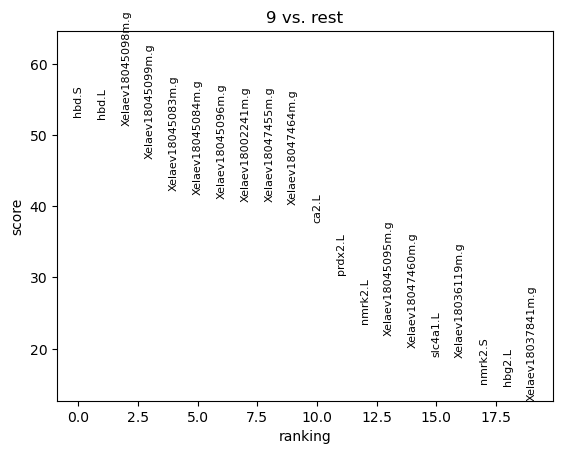

['hbd.S' 'hbd.L' 'Xelaev18045098m.g' 'Xelaev18045099m.g'
 'Xelaev18045083m.g' 'Xelaev18045084m.g' 'Xelaev18045096m.g'
 'Xelaev18002241m.g' 'Xelaev18047455m.g' 'Xelaev18047464m.g' 'ca2.L'
 'prdx2.L' 'nmrk2.L' 'Xelaev18045095m.g' 'Xelaev18047460m.g' 'slc4a1.L'
 'Xelaev18036119m.g' 'nmrk2.S' 'hbg2.L' 'Xelaev18037841m.g'
 'Xelaev18035533m.g' 'alas2.S' 'rfesd.L' 'blvrb.L' 'Xelaev18047462m.g'
 'Xelaev18047463m.g' 'tmem14c.L' 'rhd.S' 'gsta1.S' 'fam132b.L'
 'MGC86526.S' 'mthfd2.L' 'tmem38a.L' 'sptb.L' 'slc39a8.L' 'adal.L'
 'lmo2.S' 'ncoa4.L' 'Xelaev18002242m.g' 'nt5dc4.L' 'slc30a1.L'
 'Xelaev18036120m.g' 'cfb.L' 'fam65c.L' 'loc100498230.S' 'txnip.L'
 'urod.L' 'slc39a8.S' 'unnamed.L.8' 'gpx3.S']


In [30]:
sc.tl.rank_genes_groups(hvg_adata, groupby='louvain', groups=['9'],method='t-test',key_added='t_test')
top_n=50
#t-test
sc.pl.rank_genes_groups(hvg_adata, n_genes=20, sharey=False, key='t_test')
rank_genes_df_t = pd.DataFrame(hvg_adata.uns['t_test']['names'])
t_test_genes = hvg_adata.uns['t_test']['names']['9'][:top_n]
print(t_test_genes)